In [ ]:
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install tensorflow -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --upgrade setuptools -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import string

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

In [ ]:
labeled_train_df = pd.read_csv("labeled_training_incidents.csv").rename(columns={"Unnamed: 0": "index"})
print(labeled_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             5082 non-null   int64 
 1   year              5082 non-null   int64 
 2   month             5082 non-null   int64 
 3   day               5082 non-null   int64 
 4   country           5082 non-null   object
 5   title             5082 non-null   object
 6   text              5082 non-null   object
 7   hazard-category   5082 non-null   object
 8   product-category  5082 non-null   object
 9   hazard            5082 non-null   object
 10  product           5082 non-null   object
dtypes: int64(4), object(7)
memory usage: 436.9+ KB
None


In [ ]:
labeled_valid_df = pd.read_csv("labeled_validation_incidents.csv").rename(columns={"Unnamed: 0": "index"})
labeled_test_df = pd.read_csv("labeled_test_incidents.csv").rename(columns={"Unnamed: 0": "index"})

encode categorical columns before passing them to the classifier. <br>
one hot encoding for country (It's particularly suitable for nominal categorical features, where the categories have no inherent order or ranking.) <br>
Be aware of the "dummy variable trap," where multicollinearity can occur if one column can be predicted from the others..To avoid this, you can safely drop one of the one-hot encoded columns, reducing the dimensionality by one. You can declare the drop_first=True in the get_dummies function as shown below.<br>
Binary Encoding


https://kantschants.com/complete-guide-to-encoding-categorical-features#

In [ ]:
# for i in range(1):  # Iterate over the first two rows
#     print(f"Row {i+1}:")
#     print("Title:", labeled_train_df.loc[i, 'title'])
#     print("Text:", labeled_train_df.loc[i, 'text'])
#     print("-" * 80)  # Separator for readability

In [ ]:
# Extract unique hazard-category values and create a list
unique_hazard_categories = labeled_train_df["hazard-category"].unique().tolist()

# Create a mapping dictionary
hazard_category_mapping = {category: idx for idx, category in enumerate(unique_hazard_categories)}

# Create a new dataframe with text and hazard_category_label
train_st1_hazard = labeled_train_df[['text']].copy()
train_st1_hazard['label'] = labeled_train_df['hazard-category'].map(hazard_category_mapping)
print(train_st1_hazard.head())


                                                text  label
0  Case Number: 024-94   \n            Date Opene...      0
1  Case Number: 033-94   \n            Date Opene...      0
2  Case Number: 014-94   \n            Date Opene...      0
3  Case Number: 009-94   \n            Date Opene...      1
4  Case Number: 001-94   \n            Date Opene...      1


In [ ]:
# Create a new dataframe with text and hazard_category_label
valid_st1_hazard = labeled_valid_df[['text']].copy()
valid_st1_hazard['label'] = labeled_valid_df['hazard-category'].map(hazard_category_mapping)
print(valid_st1_hazard.head())

# Create a new dataframe with text and hazard_category_label
test_st1_hazard = labeled_test_df[['text']].copy()
test_st1_hazard['label'] = labeled_test_df['hazard-category'].map(hazard_category_mapping)
print(test_st1_hazard.head())

                                                text  label
0  Case Number: 017-94   \n            Date Opene...      0
1  Case Number: 048-94   \n            Date Opene...      0
2  Case Number: 032-95   \n            Date Opene...      0
3  PRESENCE OF UNDECLARED NUTS IN ORIGINALE AUGUS...      5
4  Case Number: 018-98  Recall Notification Repor...      1
                                                text  label
0  Case Number: 039-94   \n            Date Opene...      0
1  Case Number: 026-95   \n            Date Opene...      0
2  Case Number: 028-95   \n            Date Opene...      0
3  PRA No. 1998/3500 Date published 17 Mar 1998 P...      0
4  PRA No. 1998/3645 Date published 10 Sep 1998 P...      1


TF-IDF ENCODING

In [ ]:
max_features = 20000
def get_model(max_tokens=max_features, hidden_dim=16): 
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    #x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation="softmax")(x)  # 10 categories

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy']
                  )
    return model

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '\n            ', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [ ]:
print(train_st1_hazard)

                                                   text  label
0     Case Number: 024-94   \n            Date Opene...      0
1     Case Number: 033-94   \n            Date Opene...      0
2     Case Number: 014-94   \n            Date Opene...      0
3     Case Number: 009-94   \n            Date Opene...      1
4     Case Number: 001-94   \n            Date Opene...      1
...                                                 ...    ...
5077  Imported biscuit may contain allergen (peanuts...      5
5078  023-2022\n\n  \n  High - Class I\n\n    Produc...      3
5079  FRESNO, Calif. – July 28, 2022 – Lyons Magnus ...      0
5080  025-2022\n\n  \n  High - Class I\n\n    Misbra...      5
5081  024-2022\n\n  \n  High - Class I\n\n    Produc...      0

[5082 rows x 2 columns]


In [ ]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=20000,
    ngrams=2,
    output_mode="tf_idf"
)

In [ ]:
# Ensure tensors are explicitly set
train_st1_hazard_ds = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(train_st1_hazard["label"].values, dtype=tf.int32)
))

# Apply mapping
text_only_train_st1_hazard_ds = train_st1_hazard_ds.map(lambda x, y: tf.cast(x, tf.string))


In [ ]:
vectorize_layer.adapt(text_only_train_st1_hazard_ds)
# Ensure tensors are explicitly set
train_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(train_st1_hazard["label"].values, dtype=tf.int32)
))

valid_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(valid_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(valid_st1_hazard["label"].values, dtype=tf.int32)
))

test_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(test_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(test_st1_hazard["label"].values, dtype=tf.int32)
))

tfidf_2gram_train_ds = train_st1_hazard.map(
    lambda x, y: (vectorize_layer(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

tfidf_2gram_val_ds = valid_st1_hazard.map(
    lambda x, y: (vectorize_layer(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

tfidf_2gram_test_ds = test_st1_hazard.map(
    lambda x, y: (vectorize_layer(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
BATCH_SIZE = 32  # or any value that fits your GPU/memory

opt_train_ds = tfidf_2gram_train_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
opt_val_ds = tfidf_2gram_val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for x, y in opt_train_ds.take(1):
    print("X shape:", x.shape)  # Expected: (batch_size, sequence_length)
    print("Y shape:", y.shape)  # Expected: (batch_size,)


X shape: (32, 20000)
Y shape: (32,)


2025-02-07 18:57:52.440040: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
# opt_train_ds = tfidf_2gram_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# opt_val_ds = tfidf_2gram_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

model = get_model()
history = model.fit(opt_train_ds,
                    validation_data=opt_val_ds,
                    epochs=10)

Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6017 - loss: 1.6549 - val_accuracy: 0.8283 - val_loss: 0.6182
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8738 - loss: 0.4914 - val_accuracy: 0.8779 - val_loss: 0.4696
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9357 - loss: 0.2645 - val_accuracy: 0.8903 - val_loss: 0.4538
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9694 - loss: 0.1477 - val_accuracy: 0.8796 - val_loss: 0.4676
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9767 - loss: 0.0959 - val_accuracy: 0.8956 - val_loss: 0.4837
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0588 - val_accuracy: 0.8796 - val_loss: 0.5840
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9933 - loss: 0.0392 - val_accuracy: 0.8743 - val_loss: 0.6406
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9936 - loss: 0.0386 - val_accuracy: 0.

In [ ]:
def history_plotter(history):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

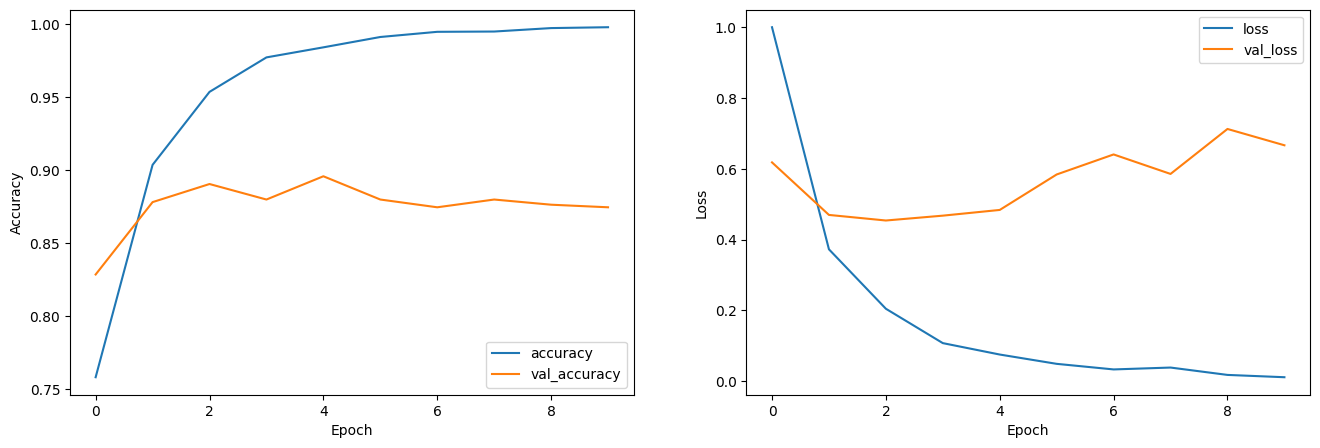

In [ ]:
history_plotter(history)

In [ ]:
tfidf_2gram_test_ds = tfidf_2gram_test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
model.evaluate(tfidf_2gram_test_ds) # loss, accuracy

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8944 - loss: 0.5719


[0.5944555997848511, 0.9017050862312317]

Evaluation

predicted labels: hazards_pred & products_pred <br>
ground truth: hazards_true & products_true

In [ ]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.